### in this notebook:

## get EL2N metric for CIFAR10, for CIFAR10 we perform ensemble size of 10 and run each for 2 epochs

## the metrics we calculate:
 - EL2N - mean of L2 Norm over the ensemble
 - pred sum - How many models were correct on each example
 - std over the ensemble

In [1]:
import os

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import tensor, Tensor
from torch.nn import functional

from train import Mode, ModelManager, DIR_ROOT_SAVE
from utils import plot_img_and_top, get_loader, get_cifar10

# globals
NUM_CLASSES = 10
BATCH_SIZE = 25
NUM_TRAIN = 50000
NUM_TEST = 10000
ENSEMBLE_SIZE = 10
ENSEMBLE_EPOCHS = 2

NOTEBOOK_NAME = 'el2n_resnet18_cifar10'
ENSAMBLE_SAVED_DATA = os.path.join(DIR_ROOT_SAVE, NOTEBOOK_NAME, 'general.pt')

print('train on:', ModelManager.DEVICE)

train_idx = np.arange(NUM_TRAIN, dtype=int)
test_idx = np.arange(NUM_TEST, dtype=int)
dataset_train, dataset_test, dataset_train_for_test, dataset_train_raw = get_cifar10()
loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE, shuffle=True)
loader_test = get_loader(dataset_test, test_idx, BATCH_SIZE, shuffle=False)
loader_train_ordered = get_loader(dataset_train_for_test, train_idx, BATCH_SIZE, shuffle=False)
Y_train = Tensor(dataset_train.targets)[train_idx].type(torch.int64)
Y_test = Tensor(dataset_test.targets)[test_idx].type(torch.int64)

train on: cuda
Files already downloaded and verified
Files already downloaded and verified


# function for calculate the EL2N scores

In [2]:
def get_el2n_scores(y: tensor, ensemble_softmax_: tensor):
    """
    calculate mean on the L2 over ensemble of algorithms

    :param y: labels, shape: (data len)
    :param ensemble_softmax_: scores for every data example, shape: (ensemble size, data len, labels len)

    :return: el2n_scores: vector of scores how the example hard to learn for every data
             shape: (data len)
    """
    y_one_hot = torch.nn.functional.one_hot(y, num_classes=ensemble_softmax_.shape[-1])
    return torch.mean(torch.linalg.norm(y_one_hot - ensemble_softmax_, ord=2, dim=2), dim=0)

### run 10 epoch for each model in ensemble, calculate the metrics and save the result to the file

In [3]:
ensemble: list[ModelManager] = [ModelManager(NUM_CLASSES, model_name=f'ensemble_{i}', dir_=NOTEBOOK_NAME, load=False)
                                for i in range(ENSEMBLE_SIZE)]
ensemble_softmax = torch.empty((len(ensemble), NUM_TRAIN, NUM_CLASSES))
ensemble_pred = torch.empty((NUM_TRAIN, len(ensemble)), dtype=torch.bool)

print()
for i, model_manager in enumerate(ensemble):
    print(f'------------   model {i}   -------------------')
    model_manager.train(loader_train, loader_test, loader_test, ENSEMBLE_EPOCHS)
    model_manager.model.cuda()
    scores, pred, loss, acc = model_manager.run_epoch(loader_train_ordered, mode=Mode.TEST)
    pred = pred.cpu()
    scores = scores.cpu()
    ensemble_softmax[i] = functional.softmax(scores, dim=1)
    ensemble_pred[:, i] = torch.Tensor(pred.type(torch.int8) == Y_train)  #.clone().detach().cpu()

ensemble_pred_sum = torch.sum(ensemble_pred, dim=1)
ensemble_std = ensemble_softmax.std(dim=0)
el2n_scores = get_el2n_scores(Y_train, ensemble_softmax)

torch.save(
    {'ensemble_softmax': ensemble_softmax, 'ensemble_pred': ensemble_pred, 'ensemble_pred_sum': ensemble_pred_sum,
     'ensemble_std': ensemble_std, 'el2n_scores': el2n_scores},
    ENSAMBLE_SAVED_DATA)


------------   model 0   -------------------
Epoch: 0 Training: Loss: 0.058648 Acc: 0.463560  Validation Loss: 0.046129 Acc: 0.577700                                                     
Validation loss decreased (inf --> 0.046129).  Saving model to models_data/el2n_resnet18_cifar10\ensemble_0
Epoch: 1 Training: Loss: 0.041785 Acc: 0.626840  Validation Loss: 0.033731 Acc: 0.704400                                                      
Validation loss decreased (0.046129 --> 0.033731).  Saving model to models_data/el2n_resnet18_cifar10\ensemble_0
Test Loss: 0.033731                                                                                                                       
Accuracy: 0.7044000000000019
------------   model 1   -------------------                                                                                               
Epoch: 0 Training: Loss: 0.057766 Acc: 0.476440  Validation Loss: 0.050923 Acc: 0.577500                                                    

In [2]:
data = torch.load(ENSAMBLE_SAVED_DATA)

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_std = data['ensemble_std']
el2n_scores = data['el2n_scores']

### Distribution of data by the pred sum metric

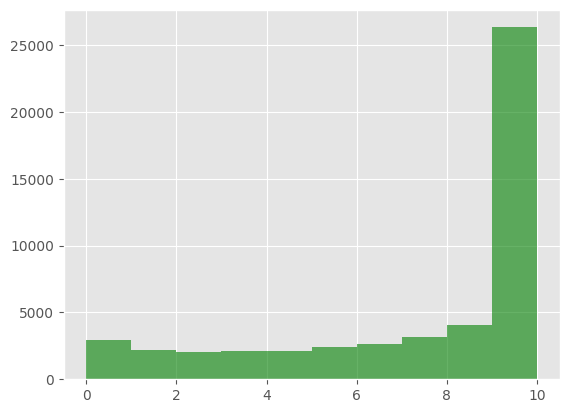

In [6]:
plt.style.use('ggplot')
plt.hist(ensemble_pred_sum, bins=ENSEMBLE_SIZE, facecolor='g', alpha=0.6)
plt.show()

### Distribution of data by the std metric

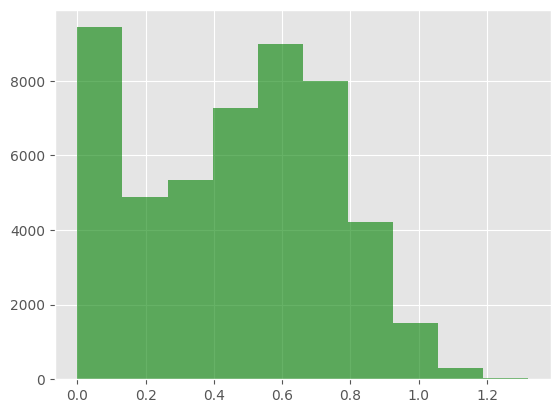

In [7]:
plt.hist(ensemble_std.sum(dim=1), facecolor='g', alpha=0.6)
plt.show()

### Distribution of data by the EL2N metric

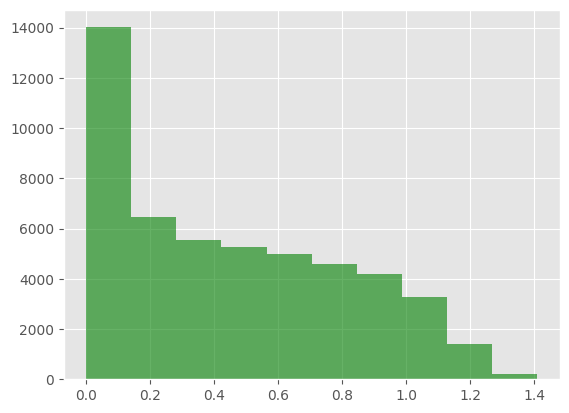

In [8]:
plt.hist(el2n_scores, bins=ENSEMBLE_SIZE, facecolor='g', alpha=0.6)
plt.show()

### plot the hardest example in rang 90%-100% according to EL2N metric

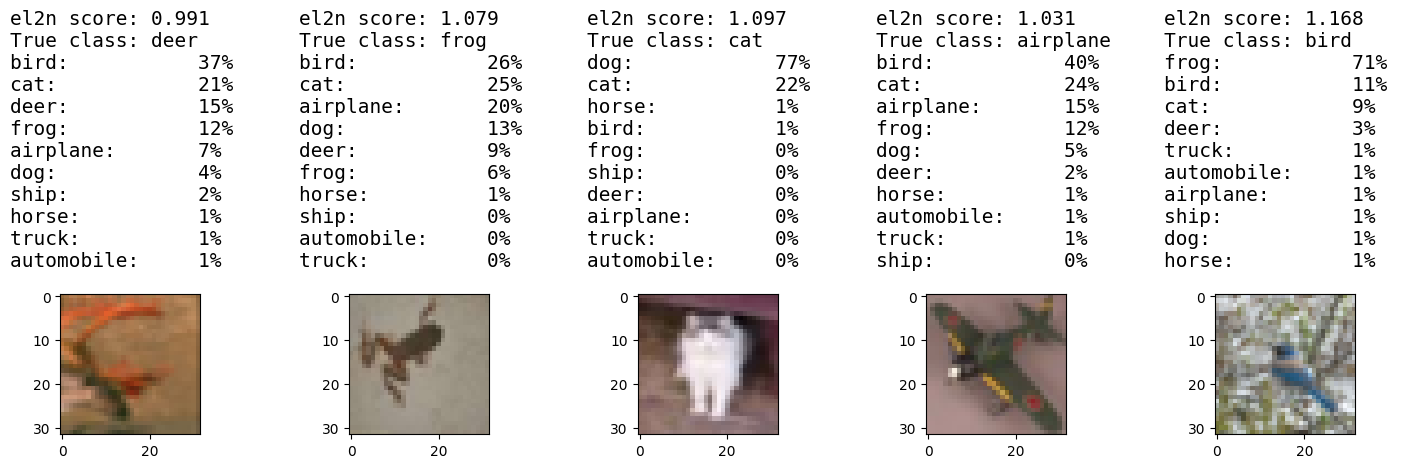

In [11]:
plot_img_and_top(dataset_train_raw, (.9, 1.), el2n_scores, ensemble_softmax, ensemble=True, score_name='el2n')

In [10]:
def pred_ensamble(ensemble_, loader, Y):
    len_dataset = len(loader.dataset)

    en_scores = torch.empty((len(ensemble_), len_dataset, NUM_CLASSES))
    en_pred = torch.empty((len(ensemble_), len_dataset))

    for model_manager_ in ensemble_:
        model_manager.model.cuda()
        scores_, pred_, loss_, acc_ = model_manager_.run_epoch(loader, mode=Mode.TEST)
        en_scores[i] = scores_.cpu()
        en_pred[i] = torch.Tensor(pred_.cpu().type(torch.int8) == Y)

    scores_mean = en_scores.mean(dim=0)
    pred_mean = torch.max(scores_mean, 1)[1]
    acc_ = torch.sum(pred_mean.eq(Y)).item() / len_dataset

    print(acc_)


pred_ensamble(ensemble, loader_test, Y_test)

0.7189                                                                                                                                    
